## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re 
import seaborn as sns
import seaborn.objects as so
from src.utils import DataProcessing as dp 
# TODO finish transfering functions to DataProcessing.py

## import data and cleaning

In [4]:
df = pd.read_csv(r'/Users/michaelschaid/GitHub/house_prediction/data/AmesHousing.tsv', delimiter='\t')
homes = dp.tweak_homes(df)
homes


,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,...,pool_area,misc_val,mo_sold,yr_sold,sale_type,sale_condition,saleprice,year_until_remod,total_sf,total_area
0,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,0,0,5,2010,WD,Normal,215000,0,4088.0,34066.0
1,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,6,2010,WD,Normal,105000,0,2800.0,13248.0
2,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,0,12500,6,2010,WD,Normal,172000,0,4416.0,16016.0
3,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,...,0,0,4,2010,WD,Normal,244000,0,6330.0,13792.0
4,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,0,0,3,2010,WD,Normal,189900,1,3731.0,15941.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,RL,7937,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,...,0,0,3,2006,WD,Normal,142500,0,3129.0,9528.0
2926,20,RL,8885,Pave,IR1,Low,AllPub,Inside,Mod,Mitchel,...,0,0,6,2006,WD,Normal,131000,0,2794.0,10271.0
2927,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,...,0,700,7,2006,WD,Normal,132000,0,2906.0,11411.0
2928,20,RL,10010,Pave,Reg,Lvl,AllPub,Inside,Mod,Mitchel,...,0,0,4,2006,WD,Normal,170000,1,4445.0,11817.0


### Basic EDA of numerical features

#### year remodeled, year built, and  $\Delta$ year_remod - year_built are correlated to sales price

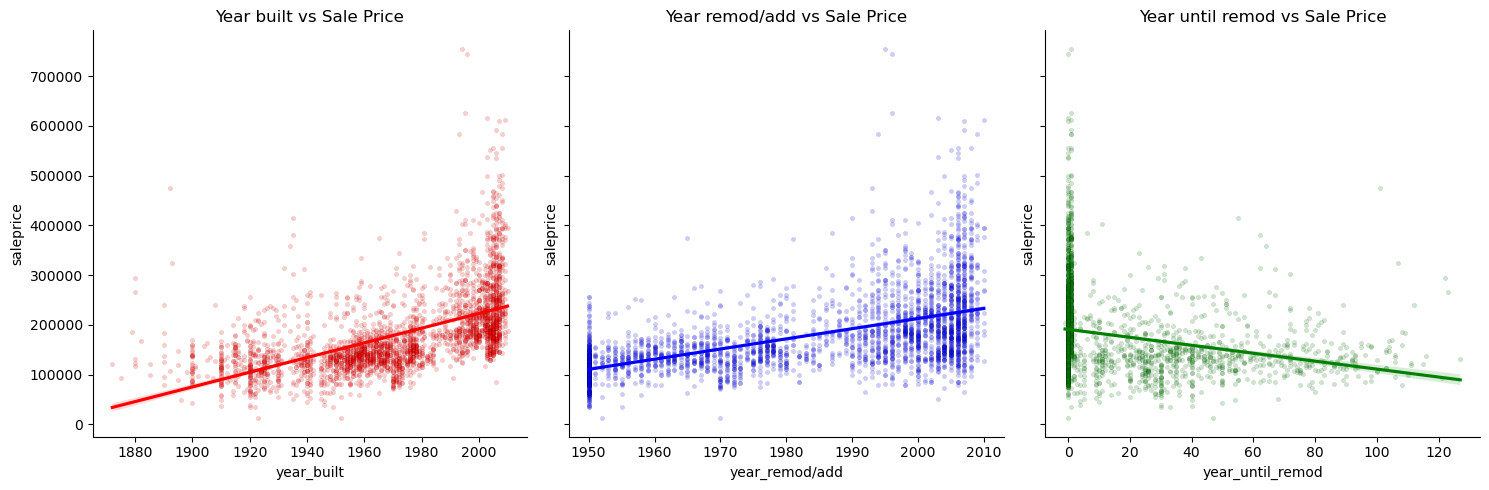

In [5]:
def year_plot(col, ax, color):
    #  function to make plots for year columns
    kws_={"s": 10,
          'alpha': 0.2,
          'edgecolor': 'black',
          'linewidth': 0.2
          }
    sns.regplot(x=col, y='saleprice', data=homes, ax=ax, color=color, scatter_kws=kws_)
    sns.despine()
    ax.set_title(f'{col.replace("_", " ").capitalize()} vs Sale Price')

#  figure generation
fig, ax = plt.subplots(figsize=(15,5), ncols=3, sharey=True)
year_plot('year_built', ax[0], color='red')
year_plot('year_remod/add', ax[1], color='blue')
year_plot('year_until_remod', ax[2], color='green')
plt.tight_layout()
plt.show()

## Total area and total sf are superior predictors for saleprice. 

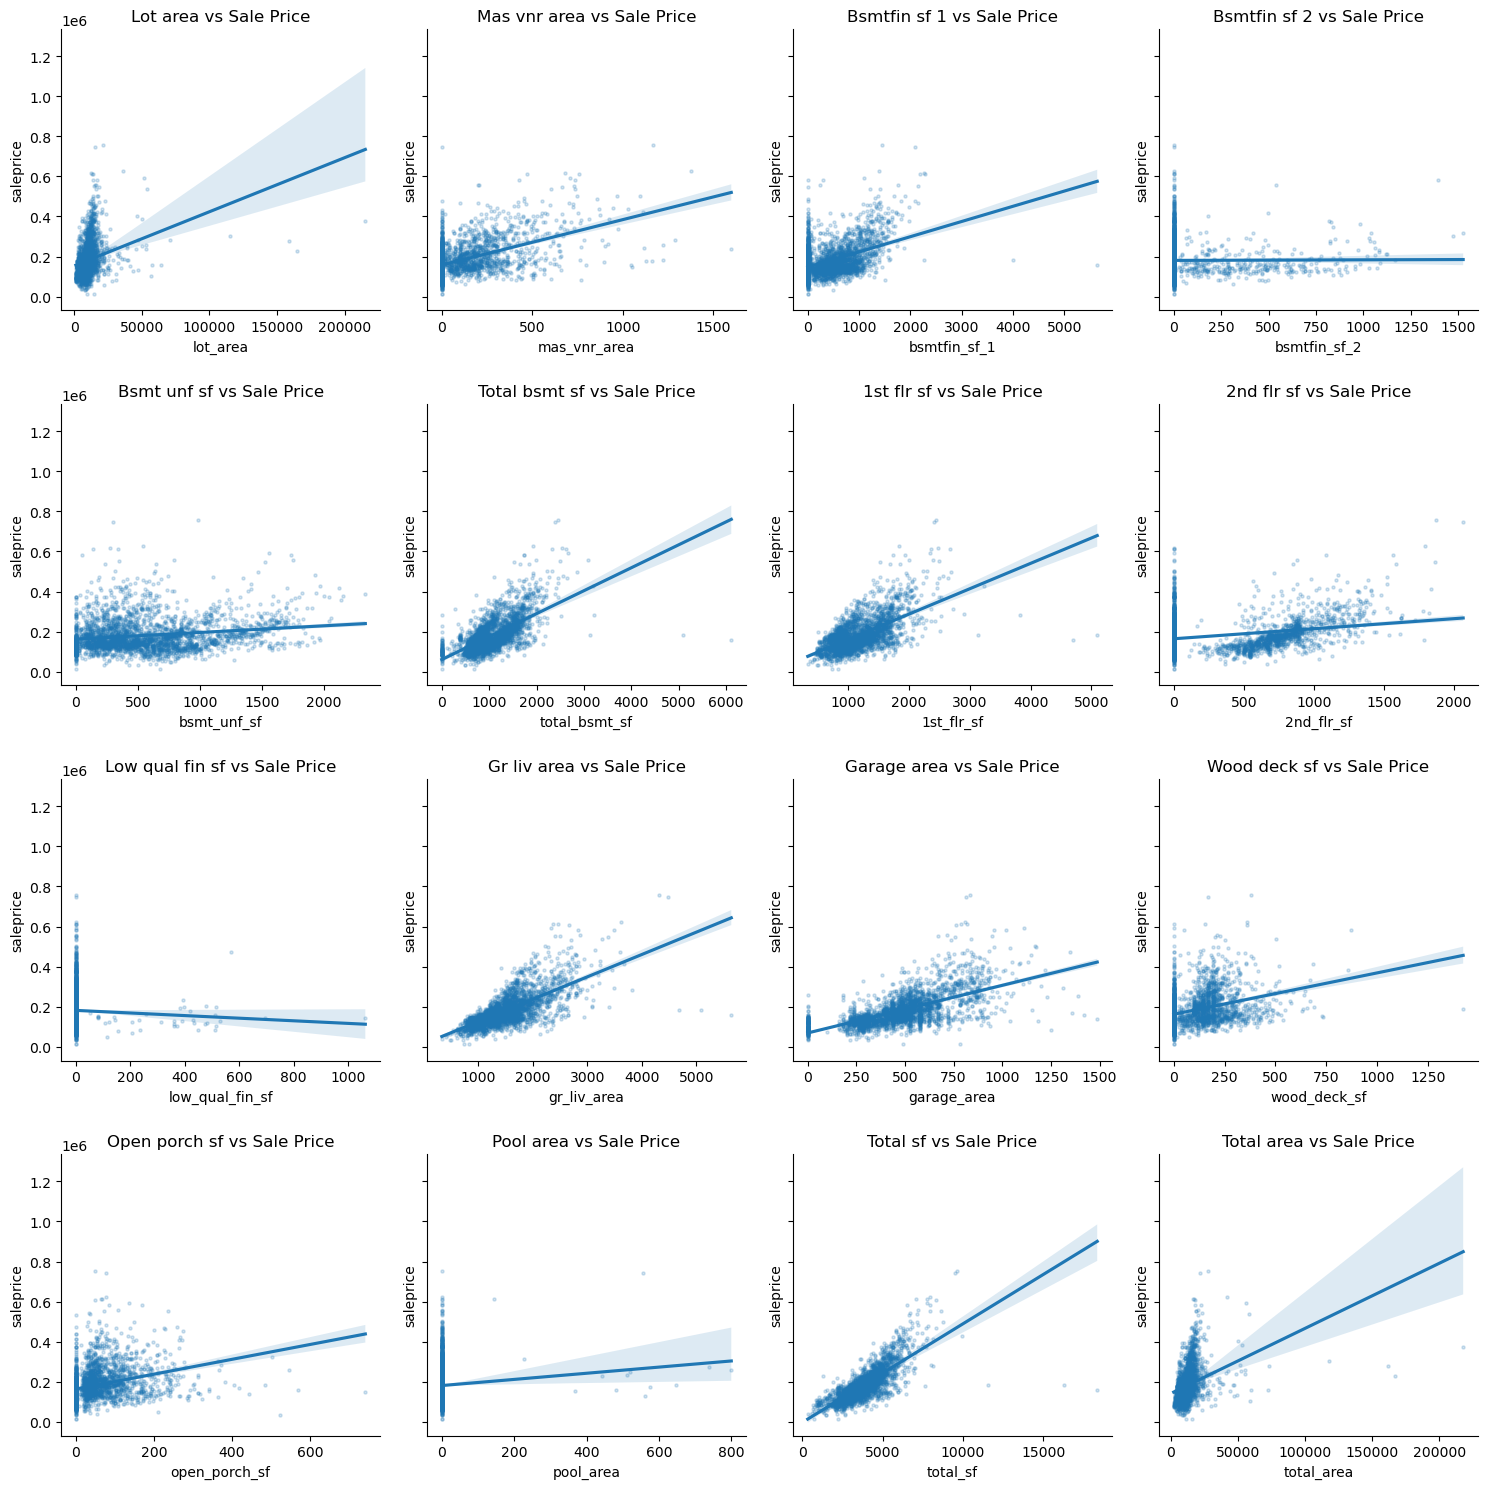

In [6]:
sqr_footage = [col for col in homes.columns if re.search(r'sf|area', col)] +['saleprice']

def make_reg_panel(cols):
    number_subplots = len(cols)-1
    grid_sqr= int(np.ceil(np.sqrt(number_subplots)))
    fig, ax = plt.subplots(figsize=(15,15), ncols=grid_sqr, nrows=grid_sqr, sharey=True)
    
    for col, ax in zip(cols, ax.flatten()):
        if col !='saleprice':
            kws_={"s": 5,'alpha': 0.2}
            sns.regplot(x=col, y='saleprice', data=homes, ax=ax, scatter_kws=kws_)
            ax.set_title(f'{col.replace("_", " ").capitalize()} vs Sale Price')
            sns.despine(ax=ax)
    
    plt.tight_layout()
    plt.show()

make_reg_panel(sqr_footage)



### EDA of categorigcal features

### neighborhood correlates mildly with overall_qual and saleprice, but qual is greater predictor.

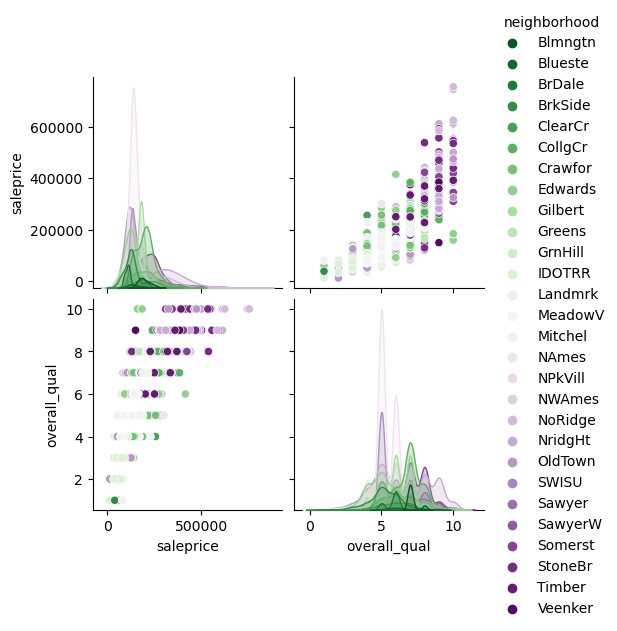

In [7]:
sns.pairplot(data=homes[['saleprice', 'overall_qual', 'neighborhood']], hue='neighborhood', palette='PRGn_r')

## Summary of Categorical Features

> Very few Categorical features have signifincat correlation with sale price and will likely be dropped
> although neighborhood has many categories, there is some degree of correlation with saleprice which makes sence 


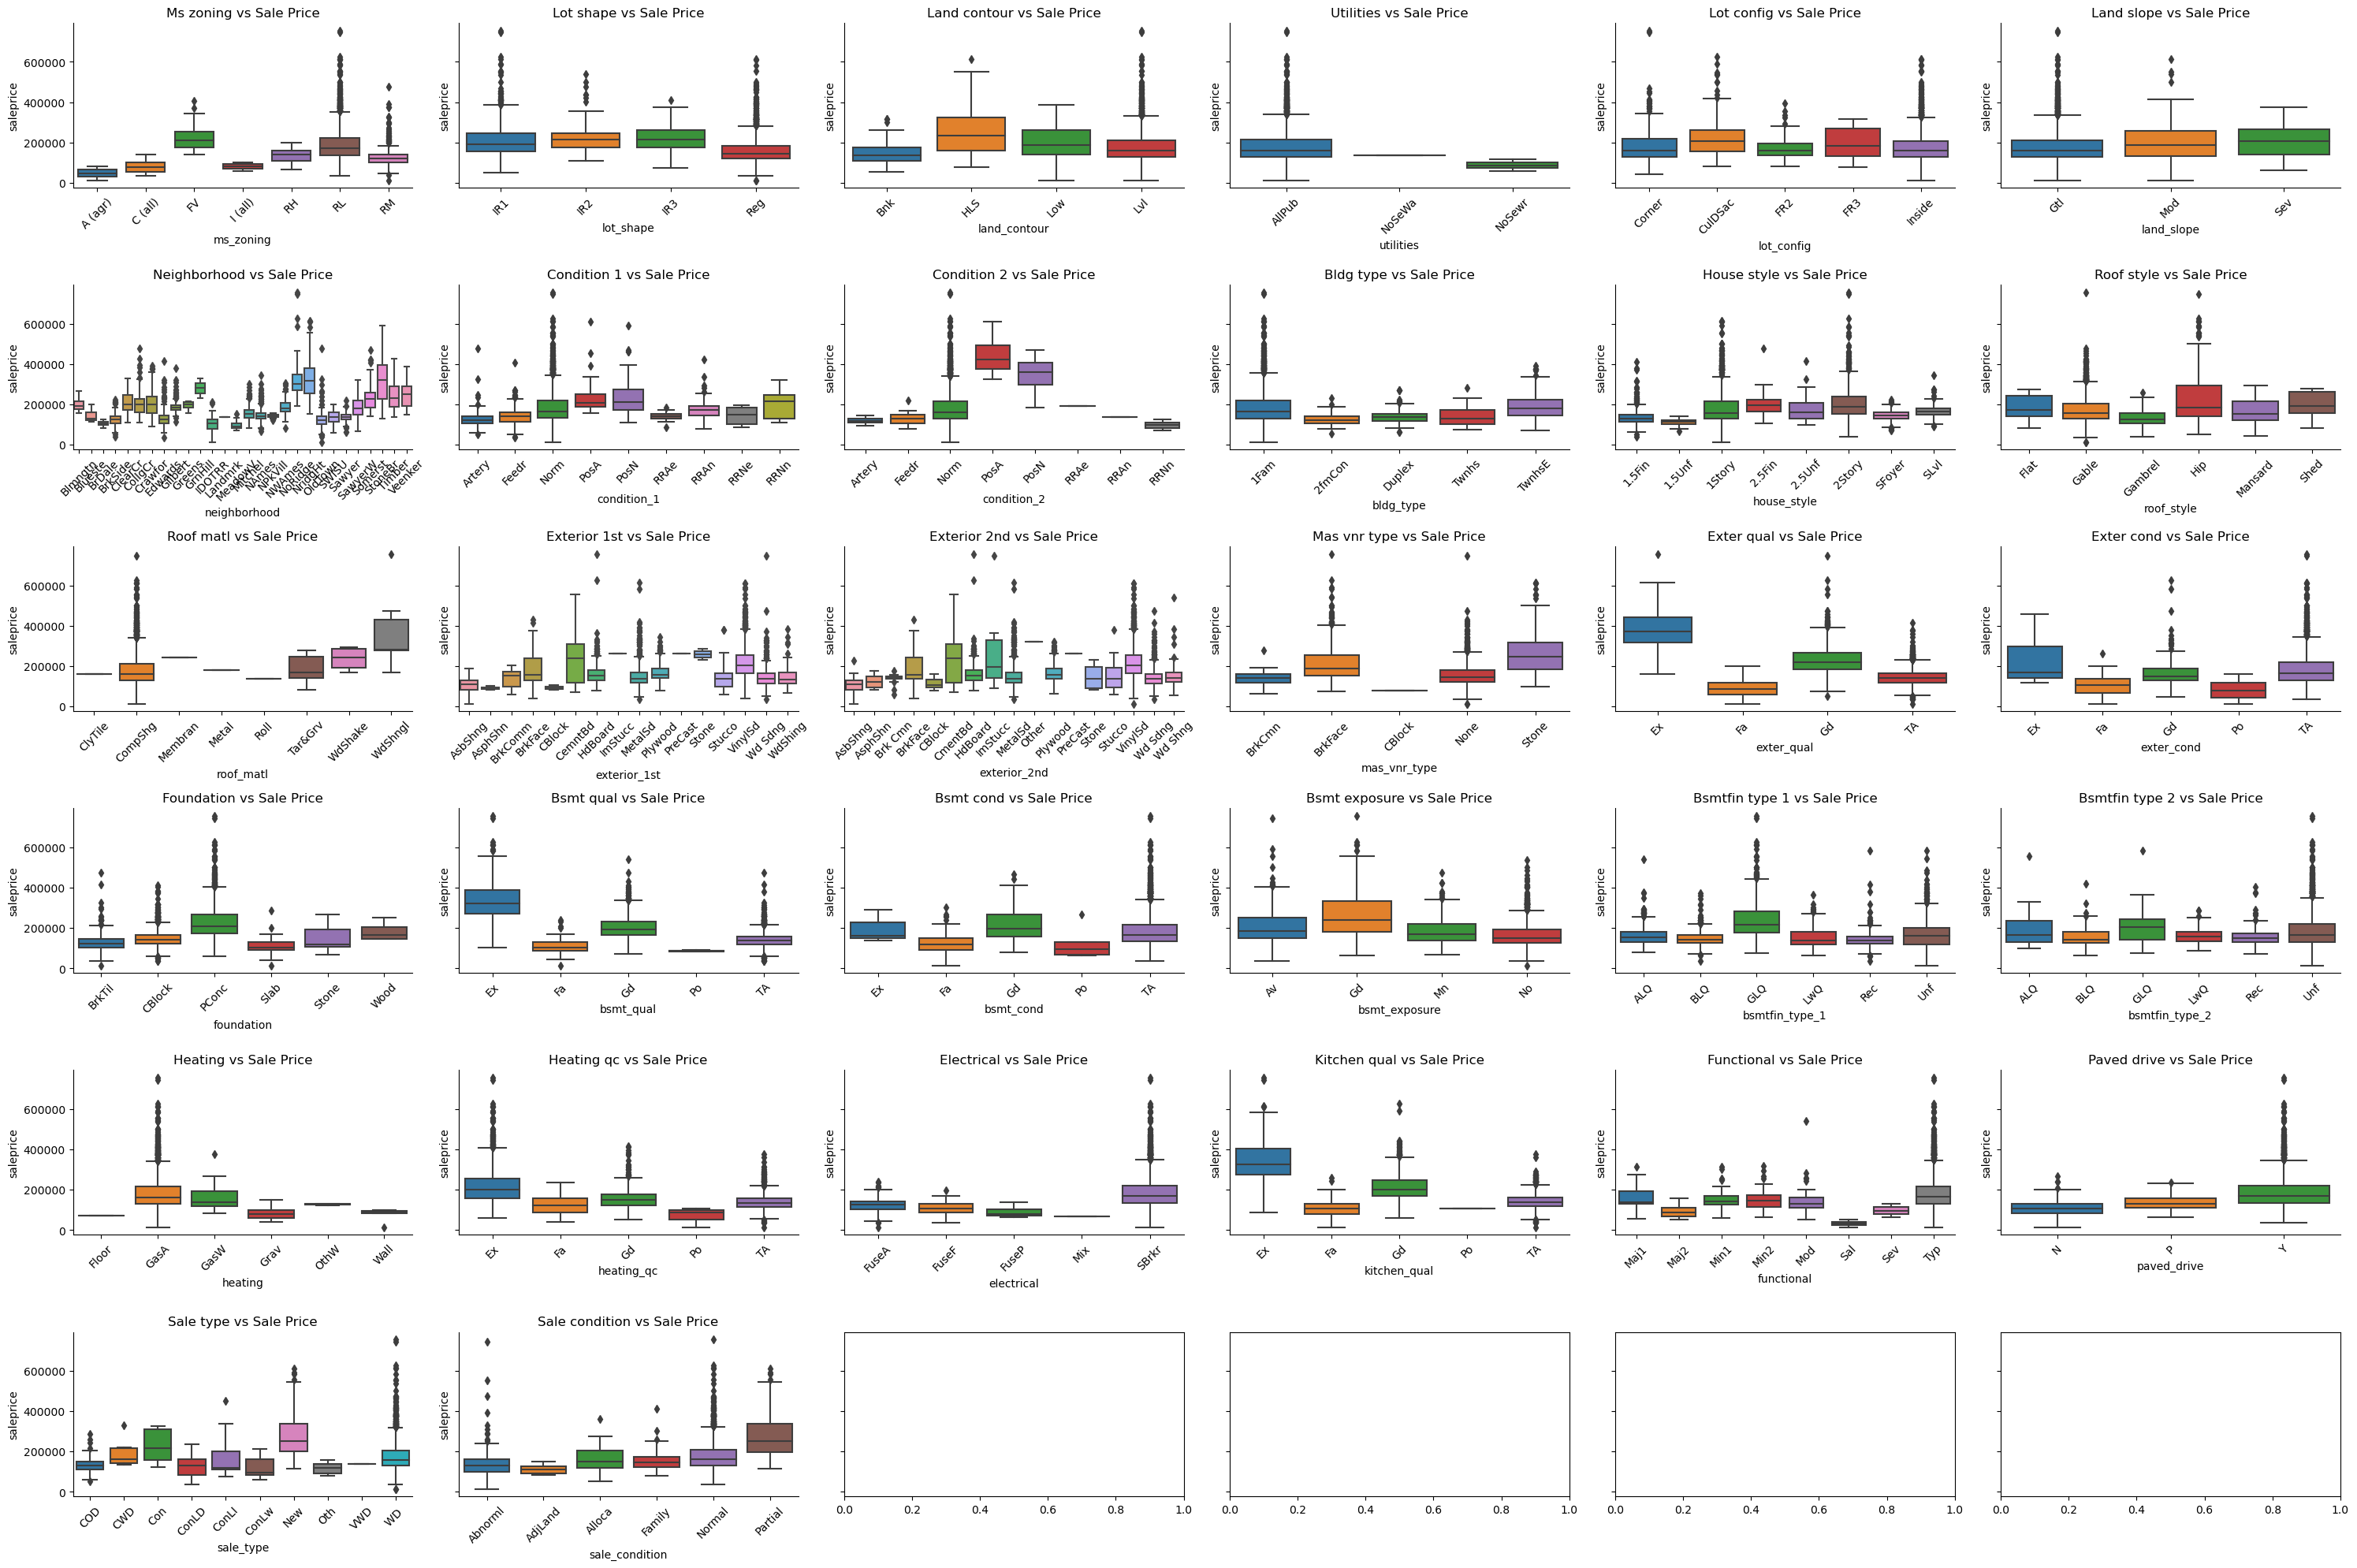

In [8]:
def plot_categorical(cat_threshold = 2):
    homes_cat = homes[homes.select_dtypes('category').columns.tolist() + ['saleprice']]
    homes_cat_gt5 = homes_cat[homes_cat.nunique()[homes_cat.nunique() > cat_threshold].index.to_list()].columns.to_list()
    panel_numb = len(homes_cat_gt5)-1
    grid_numb = int(np.ceil(np.sqrt(panel_numb)))
    
    fig, ax = plt.subplots(ncols=grid_numb, nrows=grid_numb, figsize=(30,20), sharey=True)
    for col, ax in zip(homes_cat_gt5, ax.flatten()):
        if col !='saleprice':
            sns.boxplot(x=col, y='saleprice', data=homes_cat, ax=ax)
            ax.set_title(f'{col.replace("_", " ").capitalize()} vs Sale Price')
            sns.despine(ax=ax)
            ax.tick_params(axis='x', rotation=45)
            
    plt.tight_layout()
    plt.show()
    

   
plot_categorical()

## Extraction of neighborhood features and correlation analysis of all features to saleprice

NameError: name 'drawlines' is not defined

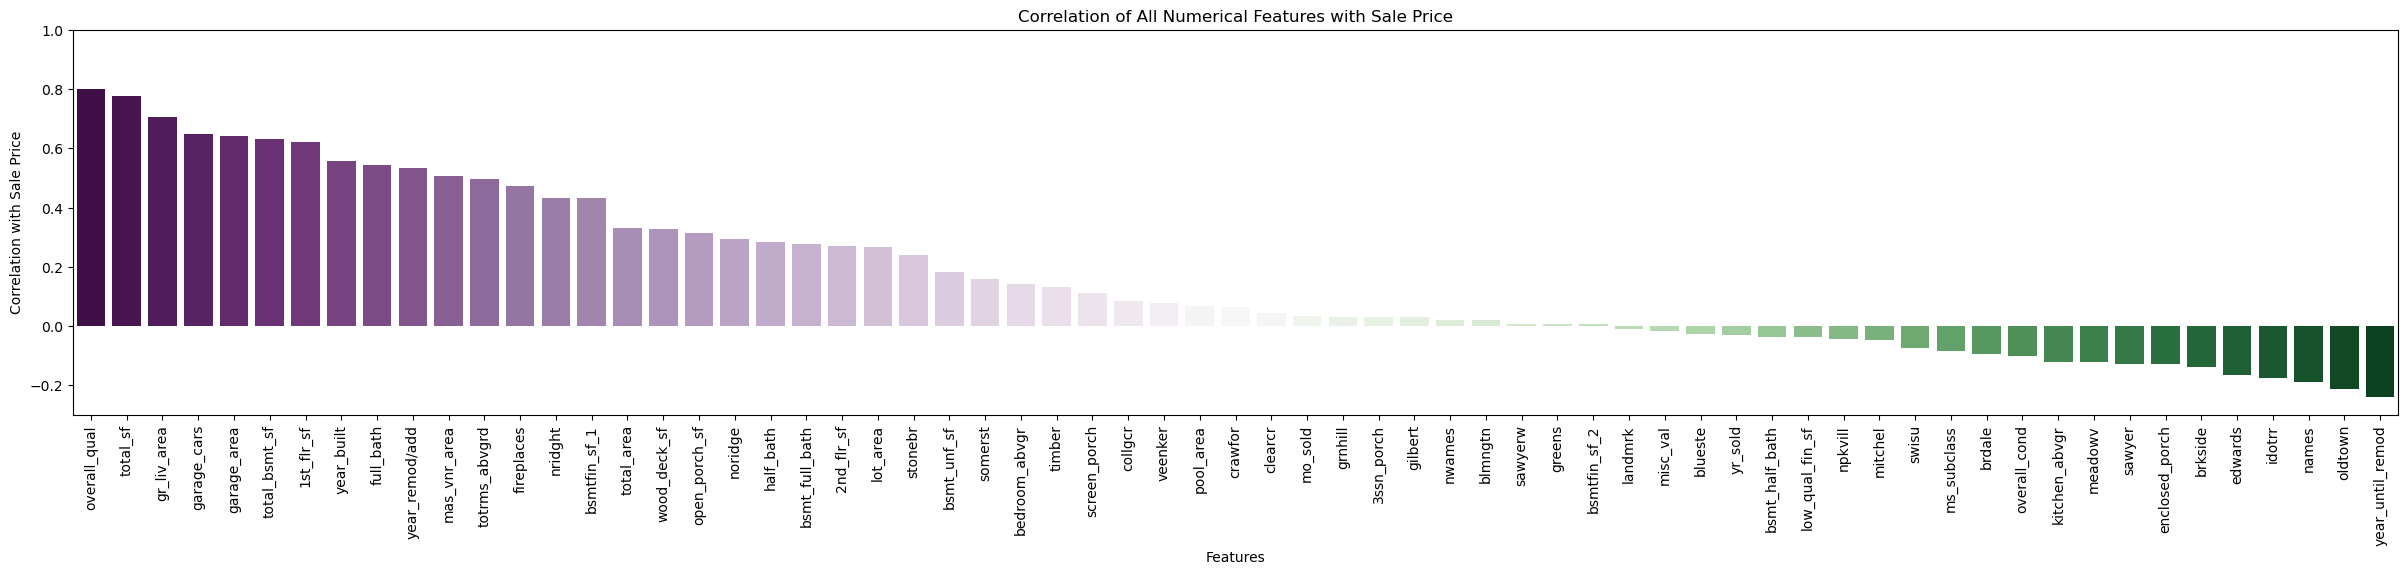

In [9]:



processed_homes = dp.get_dummies(homes)
processed_corr = pd.DataFrame(processed_homes.corr()['saleprice'].sort_values(ascending=False))

       

fig, ax = plt.subplots(figsize=(30, 5))
format = {
       'xlabel':'Features', 
       'ylabel':'Correlation with Sale Price',
       'title':'Correlation of All Numerical Features with Sale Price',
       "ylim": (-0.3, 1)    
       } 
sns.barplot(data=processed_corr.iloc[1:], x=list(processed_corr.iloc[1:].index), y='saleprice', palette='PRGn', ax=ax)

ax.set(**format)

plt.xticks(rotation=90)
drawlines(*(0.3, -0.1))
sns.despine()
ax.annotate('lines indicate threshold criteria for feature selection', xy=(150, 1), xytext=(70, 0.5))
plt.show()

In [ ]:
def select_features(lower_threshold, upper_threshold):
    corr = pd.DataFrame(processed_homes
                        .corr(numeric_only=True)['saleprice']
                        .sort_values(ascending=False)
                        )
    return (corr
            .query("saleprice < @lower_threshold or saleprice > @upper_threshold")
            .drop('saleprice', axis=0)
            .index
            .to_list()
            )

features = filter_correlated_features(-0.1, 0.3)

features

## Summary 
In this notebook we did the following: 

```{mermaid}
graph TD
    A[read data]-->
    B[clean data and extract features]-->
    C[calculate and filter high correlations]-->
    D[return processed features]
    
    
````


Final functions for processing data for training:

In [ ]:
# tweak_homes
# get_dummies
# select_features
# data to train
# homes[select_features]